### Анализ полученных данных

In [60]:
import pandas as pd
import numpy as np
import re # рабоота с регулярными выражениями

# импорт функций
from func_replace_letter import replace_letter as rep_let

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
# Настройки визуализации seaborn
sns.set(
    font_scale=0.85
)

In [3]:
data = pd.read_csv('data.csv', sep=';')

In [4]:
data['dateTime'] = pd.to_datetime(data.dateTime, format='%Y-%m-%d %H:%M:%S')
# переводим столбец в формат даты и времени

Далее не много посмотрим на данные. В результате предварительного анализа, можем обнаружить, что наши данные имеют не корректное представление. Некоторые схожие с русскими буквами представлены на английском языке. Для того, чтобы это обнаружить, воспользуемся функцией `lower()`, которая переводит все символы в нижний регистр.

In [5]:
data.productName.str.lower()

0           cалаt "oлиbьe" (сoбствeh =
1      шоkoлад (мон' дэлис руcь) "ми =
2      печеньe (тулa) maффин "ильинс =
3      cыpоk глазир. (б.ю.aлеkсahдpо =
4      бx: бymагa тyалетhая "mягkий  =
                    ...               
321         п/ф карбoнад cвиhoй (п/ф =
322         pыба koпч.(арт-pыба) 3уб =
323    cmetahа (toтьмa) "boлогoдская =
324    cmеtаhа (тотьma) "bолoгoдckaя =
325     твоpoг (тотьмa) oбeзжирehhый =
Name: productName, Length: 326, dtype: object

Чтобы устранить не корректный ввод данных, создадим функцию `replace_letter`, которая заменяет английские символы на русские `k -> к` и возвращает исправленное наименование товара в нижнем регистре.

Функция описана в файле `func_replace_letter.py`

In [6]:
data['productName'] = data.productName.apply(rep_let)

In [7]:
print('Всего кол-во позиций:', data.shape[0], sep='\t')
# обратим внимание, что мы имеем 326 уникальных позиций товара
print('Всего кол-во чеков:', data.dateTime.nunique(), sep='\t')
# а также данные содержат всего 84 чека в промежутке с 1 апр.2022 по 8 нояб.2022

Всего кол-во позиций:	326
Всего кол-во чеков:	84


Данные загружены и отредактированы. С 1 апреля по 8 ноября имеется всего 84 чека, что является незначительным для такого промежутка времени. Сгруппируем данные по дате и визуализируем общую сумму покупок в каждом месяце.

In [8]:
data_group_date = data \
    .groupby('dateTime', as_index=False) \
    .agg({'purchaseAmount': 'sum'})

In [9]:
data_group_month = data.set_index(data.dateTime).purchaseAmount.resample('M').sum().to_frame().reset_index()

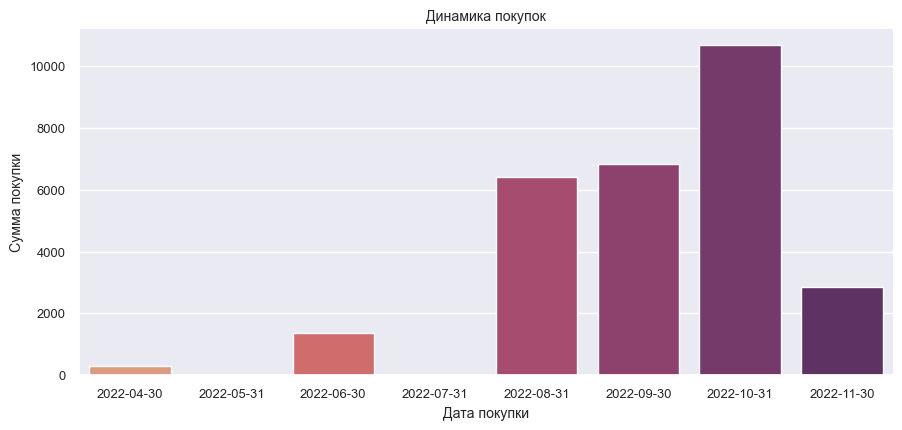

In [10]:
plt.figure(figsize=(10.5, 4.5))
ax = sns.barplot(data=data_group_month, x='dateTime', y='purchaseAmount',
                 palette="flare") # строим график
ax.set(xlabel='Дата покупки', ylabel='Сумма покупки', title='Динамика покупок') # именуем оси, наименовние графика
ax.set_xticklabels(data_group_month.dateTime.dt.date)
sns.despine() # убираем часть рамки
plt.show() # печатаем график

По данному графику можно сделать вывод, что с `апреля` по `июль` сумма покупок незначительна, поэтому для дальнейшего анализа оставим в выборке значения с `августа 2022` года.

In [11]:
data_active = data.query('dateTime > \'2022-07-31\'').reset_index(drop=True)
# отбираем данные с августа 2022 года

Для начала посмотрим частоту встречаемости каждой позиции / кол-во и объем покупок каждого товара и выберем наиболее популярные позиции.

In [12]:
data_active.productName.value_counts().head()

корм д/кошек "реrfест fiт" 75 =     17
для розницы: пакет-майка малый =    14
хлеб (вологодский хк) "дарниц =     14
газ.напиток (кириллов) о,5л с =     12
корм д/кошек "шеба" 75г в асс =     11
Name: productName, dtype: int64

По представленным выше данным мы видим `топ-5` позиций пользователя. На втором месте находится `пакет` - данный товар исключим из нашего `DataFrame` т.к. он не представляет для нас интереса.

In [13]:
data_active = data_active.drop(index = data_active \
    .query('productName == \'для розницы: пакет-майка малый =\'') \
    .index)

```python
data_active.to_excel('data.xlsx')
# сохраним данные в Excel для наглядного представления данных
```

In [14]:
data_active.productName.value_counts().head()

корм д/кошек "реrfест fiт" 75 =    17
хлеб (вологодский хк) "дарниц =    14
газ.напиток (кириллов) о,5л с =    12
корм д/кошек "шеба" 75г в асс =    11
фрукты: бананы 1кг        =         9
Name: productName, dtype: int64

In [15]:
top_5_product = data_active.productName.value_counts().head().index
# топ-5 наиболее популярных продуктов

In [16]:
data_active = data_active.assign(month=data_active.dateTime.dt.month)

In [17]:
data_top_5_product = data_active \
    .query('productName in @top_5_product')[['month', 'productName']]

In [18]:
top_5_product_quantity = data_active \
    .groupby('productName', as_index=False) \
    .agg({'quantity': 'sum'}) \
    .sort_values('quantity', ascending=False) \
    .head()
# группировка по кол-ву купленного товара

In [19]:
top_5_product_quantity

,productName,quantity
39,"корм д/кошек ""реrfест fiт"" 75 =",67.0
41,"корм д/кошек ""шеба"" 75г в асс =",28.0
40,"корм д/кошек ""реrfест fiт"" па =",17.0
18,"газ.напиток (кириллов) о,5л с =",16.0
135,"хлеб (вологодский хк) ""дарниц =",14.0


In [20]:
top_5_product_amount = data_active \
    .groupby('productName', as_index=False) \
    .agg({'purchaseAmount': 'sum'}) \
    .sort_values('purchaseAmount', ascending=False) \
    .head()

In [21]:
top_5_product_amount

,productName,purchaseAmount
39,"корм д/кошек ""реrfест fiт"" 75 =",1736.63
37,"корм д/кошек ""реrfест fiт"" 1 =",1627.17
78,"пиво (бавария) ""семен дежнев =",939.93
41,"корм д/кошек ""шеба"" 75г в асс =",795.72
18,"газ.напиток (кириллов) о,5л с =",664.24


Можем обратить внимание, что во всех трёх выборках встречается `корм д/кошек` и `газ.напиток`. Отсюда можем сделать предположение, что эти товары являются наиболее интересными покупателю.

Но обратим внимание, что однотипный товар (например, `корм д/кошек`) занимает сразу несколько позиций нашего `топ-списка`. Попробуем преобразовать данный товар. Для этого воспользуемся регулярными выражениями и найдем все позиции `корм д/кошек`.

In [22]:
data_active_product_cat = data_active[data_active.productName.str.contains('^корм д/кошек', regex=True)]

In [23]:
data_active_product_cat \
    .sort_values('price', ascending=False) \
    .head(10)
# посмотрим на первые 10 позиций отобранного товара

,dateTime,userInn,productName,price,quantity,purchaseAmount,month
103,2022-09-19 18:53:00,352500101378,"корм д/кошек ""реrfест fiт"" 1 =",579.99,1.0,579.99,9
51,2022-08-26 20:02:00,352500101378,"корм д/кошек ""реrfест fiт"" 1 =",559.99,1.0,559.99,8
254,2022-10-27 13:48:00,352500101378,"корм д/кошек ""реrfест fiт"" 1 =",487.19,1.0,487.19,10
170,2022-10-08 16:41:00,352500101378,"корм д/кошек ""реrfест fiт"" 6 =",315.49,1.0,315.49,10
143,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" 75 =",30.99,3.0,92.97,9
142,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" 75 =",30.99,3.0,92.97,9
145,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" 75 =",30.99,3.0,92.97,9
146,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" па =",30.99,6.0,185.94,9
147,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" па =",30.99,3.0,92.97,9
144,2022-09-26 18:26:00,352500101378,"корм д/кошек ""реrfест fiт"" 75 =",30.99,3.0,92.97,9


Отсортированные данные по цене показывают, что `корм д/кошек` имеется не только различной марки, но и различной ценовой категории. В данном случае мы заблаговременно знаем, что корм, стоимостью `свыше 100 руб.` является сухим кормом д/кошек, а корм, стоимостью `ниже 100 руб.` является жидким. Отфильтруем данные и переименуем `productName`.

+ корм со стоимостью `>= 100 руб.` переименуем как `сухой корм д/кошек`
+ корм со стоимостью `< 100 руб.` переименуем как `жидкий корм д/кошек`

In [24]:
arr_liquid_food = data_active_product_cat \
    .query('price < 100') \
    .productName \
    .unique()
# массив наименований сухого корма

In [25]:
arr_dry_food = data_active_product_cat \
    .query('price >= 100') \
    .productName \
    .unique()
# массив наименований жидкого корма

In [26]:
dict_rename = dict()
for val in arr_dry_food:
    dict_rename[val] = 'сухой корм д/кошек'
# создаем map сухого корма

for val in arr_liquid_food:
    dict_rename[val] = 'жидкий корм д/кошек'
# создаем map жидкого корма

In [27]:
data_active['productName'] = data_active.productName.replace(dict_rename)

После успешного переименования давайте попробуем посмотреть, как часто пользователь покупает данный товар.

In [28]:
data_prod_cat = data_active[data_active.productName.str.contains('корм д/кошек$', regex=True)]

In [29]:
data_prod_cat.head()

,dateTime,userInn,productName,price,quantity,purchaseAmount,month
0,2022-08-14 14:25:00,352500101378,жидкий корм д/кошек,27.99,3.0,83.97,8
1,2022-08-14 14:25:00,352500101378,жидкий корм д/кошек,27.99,3.0,83.97,8
2,2022-08-14 14:25:00,352500101378,жидкий корм д/кошек,27.99,4.0,111.96,8
28,2022-08-19 10:18:00,352500101378,жидкий корм д/кошек,29.99,4.0,119.96,8
29,2022-08-19 10:18:00,352500101378,жидкий корм д/кошек,29.99,3.0,89.97,8


In [30]:
data_prod_cat_group = data_prod_cat \
    .groupby(['month', 'productName'], as_index=False) \
    .agg({'quantity': 'sum', 'purchaseAmount': 'sum'}) \
    .rename(columns={'productName': 'Наименование товара'})

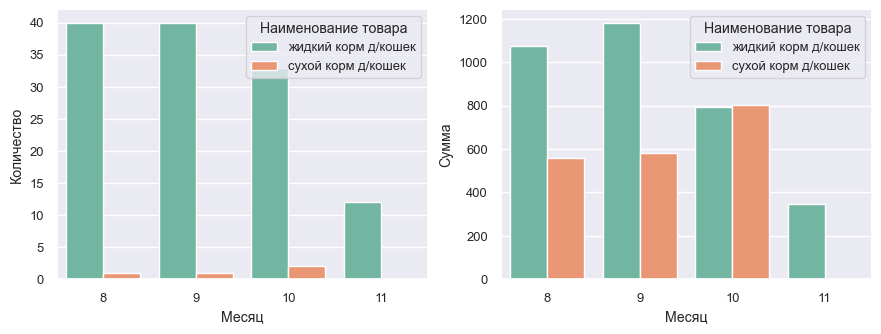

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10.5, 3.5))

sns.barplot(
                data=data_prod_cat_group,
                x='month',
                y='quantity',
                hue='Наименование товара',
                palette="Set2",
                ax=ax1
            ) # кол-во товаров
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество')

sns.barplot(
                data=data_prod_cat_group,
                x='month',
                y='purchaseAmount',
                hue='Наименование товара',
                palette="Set2",
                ax=ax2
            ) # сумма покупки
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Сумма')

sns.despine()
plt.show()

По графику мы можем наблюдаеть снижение кол-ва приобретенных товаров `жидкий корм д/кошек`, при этом также наблюдается и снижение выручки по данному товару в разрезе покупателя.

А также наблюдается рост приобретенных товаров `сухой корм д/кошек` с увеличением выручки по данному товару в разрезе покупателя.

In [32]:
data_prod_cat = data_prod_cat.assign(weekday = data_prod_cat.dateTime.dt.weekday)

In [33]:
data_prod_cat_group_dt = data_prod_cat \
    .groupby(['dateTime', 'productName'], as_index=False) \
    .agg({'quantity': 'sum', 'purchaseAmount': 'sum'}) \
    .rename(columns={'productName': 'Наименование товара'})

In [79]:
data_prod_cat_group_dt = data_prod_cat_group_dt.assign(date=data_prod_cat_group_dt.dateTime.dt.date)

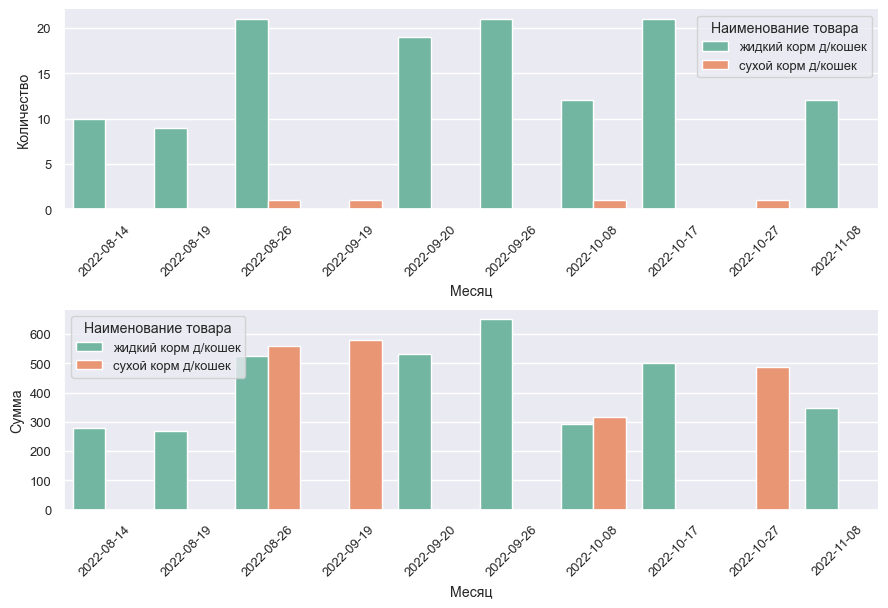

In [91]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10.5, 6.5))
plt.subplots_adjust(hspace=0.5)

sns.barplot(
                data=data_prod_cat_group_dt,
                x='date',
                y='quantity',
                hue='Наименование товара',
                palette="Set2",
                ax=ax1
            ) # кол-во товаров
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.barplot(
                data=data_prod_cat_group_dt,
                x='date',
                y='purchaseAmount',
                hue='Наименование товара',
                palette="Set2",
                ax=ax2
            ) # сумма покупки
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Сумма')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)

sns.despine()
plt.show()

По графикам можно сделать вывод, что `сухой корм д/кошек` покупается примерно 1 раз в месяц, а `жидкий корм д/кошек`, примерно каждую неделю.

In [124]:
df_liquid_food = data_prod_cat \
    .groupby(['dateTime', 'productName'], as_index=False) \
    .agg({'quantity': 'sum'}) \
    .query('productName==\'жидкий корм д/кошек\'')

df_dt_liquid_food = df_liquid_food[['dateTime']]

In [125]:
df_dt_liquid_food_shift = df_dt_liquid_food \
    .assign(dateTimeShift = df_dt_liquid_food.dateTime.shift(-1))

In [126]:
avg_timedelta_buy_liquid_food = (df_dt_liquid_food_shift.dateTimeShift - df_dt_liquid_food_shift.dateTime).mean()
# среднее время, через которое произойдет очередная покупка

In [127]:
df_dt_liquid_food.max() + avg_timedelta_buy_liquid_food
# когда произойдет следующая покупка

dateTime   2022-11-20 19:50:42.857142857
dtype: datetime64[ns]

In [135]:
round(df_liquid_food.quantity.mean())

16

**По данным можно сделать вывод, что 2022-11-20 пользователь вновь совершит покупку `жидкий корм д/кошек` в кол-ве 16 шт.**